In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import galsim as gs
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.units import Unit as u
from copy import copy, deepcopy

from kl_tools.kross.data import get_kross_obj_data
from kl_tools.kross.cube import KROSSDataCube
from kl_tools.kross.tfr import estimate_vtf
from kl_tools.velocity import VelocityMap
from kl_tools.intensity import IntensityMapFitter
from kl_tools.coordinates import OrientedAngle
from kl_tools.basis import build_basis
from kl_tools.utils import add_colorbar, build_map_grid

Name: C-zcos_z1_925
z: 0.9128704040824489


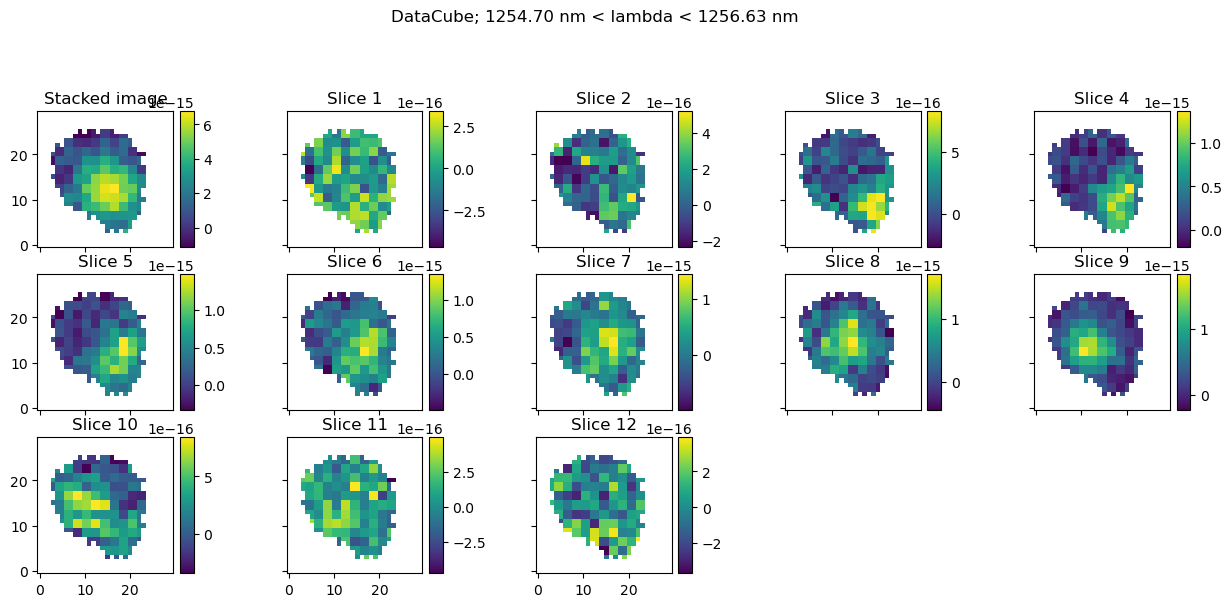

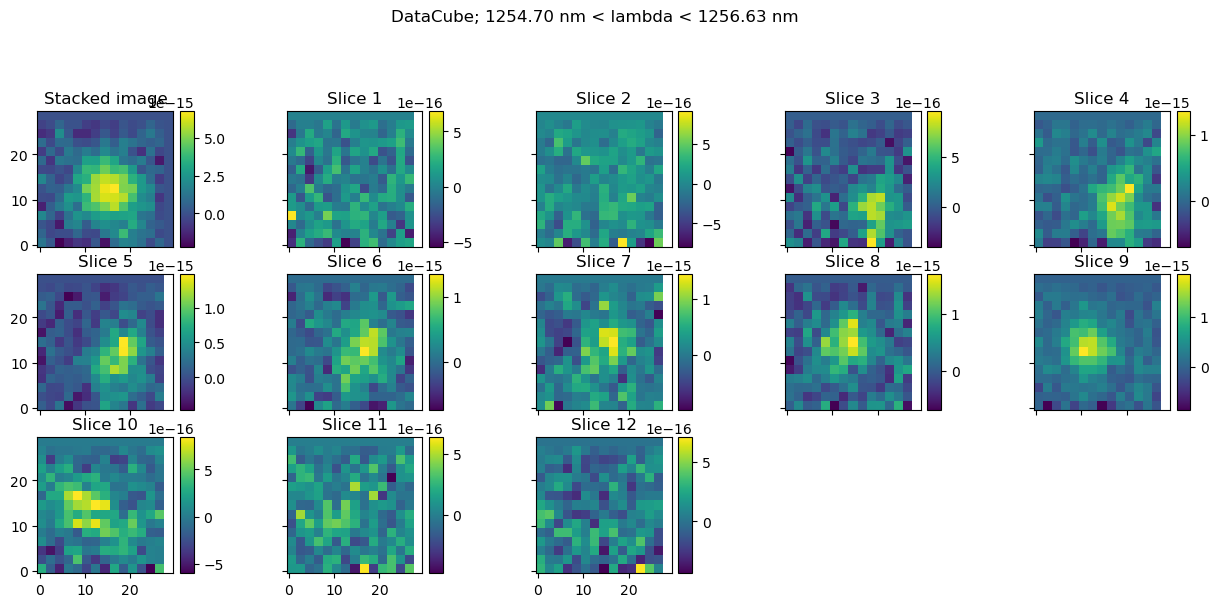

10h00m56.2704s +02d18m41.01912s


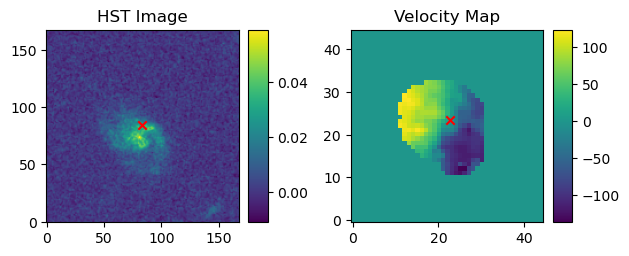

In [6]:
# global settings
plot = True

kid = 171
cube = KROSSDataCube(kid)

# truncate to the Halpha line
cube.set_line('Ha')

# might be helpful later on
obj_data = get_kross_obj_data(kid)

image = obj_data['hst']
image_wcs = WCS(obj_data['hst_hdr'])
vmap = obj_data['velocity']
vmap_wcs = WCS(obj_data['velocity_hdr'])

name = obj_data['catalog']['NAME'][0]
z = obj_data['catalog']['Z'][0]
print(f'Name: {name}')
print(f'z: {z}')

if plot is True:
    # mask on
    cube.plot(show=True, mask=True, max_cols=5)
    # mask off
    cube.plot(show=True, mask=False, max_cols=5)

    # get the center of the obj
    row = obj_data['catalog']
    ra = row['RA'][0]
    dec = row['DEC'][0]
    coord = SkyCoord(ra, dec, unit='deg')
    print(coord.to_string('hmsdms'))

    image_center = image_wcs.world_to_pixel(coord)
    vmap_center = vmap_wcs.world_to_pixel(coord)

    plt.subplot(121)
    im = plt.imshow(image, origin='lower')
    add_colorbar(im)
    plt.scatter(*image_center, marker='x', color='r')
    plt.title('HST Image')

    plt.subplot(122)
    im = plt.imshow(vmap, origin='lower')
    add_colorbar(im)
    plt.scatter(*vmap_center, marker='x', color='r')
    plt.title('Velocity Map')

    # plt.suptitle(f'KID {kid} Data Vector')
    plt.tight_layout()
    plt.show()

    # One at at time, with WCS projection
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection=image_wcs)
    # im = ax.imshow(image, origin='lower')
    # ax.scatter(*image_center, marker='x', color='r')
    # # add_colorbar(im)
    # ax.set_title('HST Image')
    # fig.set_size_inches(4, 4)
    # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection=vmap_wcs)
    # im = ax.imshow(vmap, origin='lower')
    # # add_colorbar(im)
    # ax.scatter(*vmap_center, marker='x', color='r')
    # ax.set_title('Velocity Map')
    # fig.set_size_inches(4, 4)
    # plt.show()

### New 2x2D datavector

Vmap pixel scale: 0.10000008
image pixel scale: 0.029999998800000004
---------
vtf: 142.31
vlow: 64.10
vhigh: 401.26
---------
sini: 0.71
sini_low: 0.54
sini_high: 0.89
---------
Initial theta: [  0.         101.66416411   0.30000024   0.71440773   2.54818071
   0.           0.           0.           0.          10.
   0.29999999   0.14999999   0.           0.           0.99938259]
Optimization success: True
Optimized parameters: [-3.09397894e+00  1.14069068e+02  1.50000120e-01  8.43836304e-01
  2.57305772e+00 -1.00000000e-04  1.00000000e-04 -1.52974758e+00
 -1.85765613e+00  1.00027434e+01  3.53455295e-02  1.62335760e-02
  3.68677398e-01 -8.53227694e-01 -7.77506013e-01]
{'v0': -3.093978938541131, 'vcirc': 114.06906827088723, 'rscale': 0.15000012000000001, 'sini': 0.8438363043071212, 'theta_int': 2.57305772129569, 'g1': -0.0001, 'g2': 0.0001, 'vmap_x0': -1.5297475754012746, 'vmap_y0': -1.857656126898584, 'r_unit': Unit("arcsec"), 'v_unit': Unit("km / s")}
{'v0': -3.093978938541131, 'vci

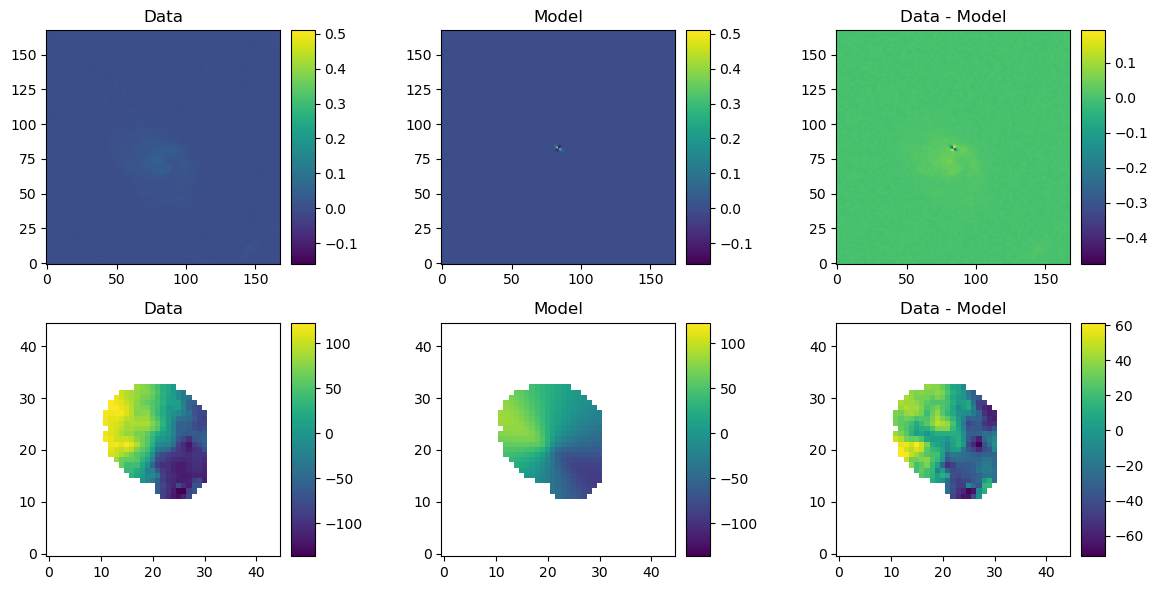

In [ ]:
def theta2pars(theta, r_unit=u('arcsec'), v_unit=u('km/s'), pars_type='both'):
    '''
    Map a fixed array of parameters to a dict of vmap parameters.

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    vmap_pars = {
        'v0': theta[0],
        'vcirc': theta[1],
        'rscale': theta[2],
        'sini': theta[3],
        'theta_int': theta[4],
        'g1': theta[5],
        'g2': theta[6],
        'vmap_x0': theta[7],
        'vmap_y0': theta[8],
        'r_unit': r_unit,
        'v_unit': v_unit,
    }

    image_pars = {
        'flux': theta[9], # total flux of the disk
        'hlr': theta[10], # half-light radius of the disk,
        'beta': theta[11], # scale factor for the basis functions, in arcsec
        'image_x0': theta[12],
        'image_y0': theta[13],
        'basis': theta[14:] # arbitrary number of basis coefficients
    }

    if pars_type == 'vmap':
        pars = vmap_pars
    elif pars_type == 'image':
        pars = image_pars
    else:
        pars = {**vmap_pars, **image_pars}

    return pars

def pars2theta(pars):
    '''
    Map a dict of vmap parameters to a fixed array of parameters for the fitter

    We have more general tools to handle this, but this is a simple
    way to handle the fixed parameters in the KROSS model.
    '''

    theta_vmap = [
        pars['v0'],
        pars['vcirc'],
        pars['rscale'],
        pars['sini'],
        pars['theta_int'],
        pars['g1'],
        pars['g2'],
        pars['vmap_x0'],
        pars['vmap_y0'],
    ]

    theta_image = [
        pars['flux'], # total flux of the disk
        pars['hlr'], # half-light radius of the disk,
        pars['beta'], # scale factor for the basis functions, in arcsec
        pars['image_x0'],
        pars['image_y0'],
        pars['basis']
    ]

    return np.array(theta_vmap + theta_image)

def make_model_image(theta, image_data):
    image = image_data[0]
    image_wcs = image_data[3]
    shape = image.shape
    Nrow, Ncol = shape
    Nx, Ny = Ncol, Nrow

    # get the model pars
    pars_vmap = theta2pars(theta, pars_type='vmap')
    pars_image = theta2pars(theta, pars_type='image')

    # get the pixel scale of the image
    cd_matrix = image_wcs.pixel_scale_matrix
    pixel_scales = np.sqrt((cd_matrix**2).sum(axis=0))
    pixel_scale = 3600 * np.mean(pixel_scales) # arcsec

    # setup the basis
    Nbasis = len(pars_image['basis'])
    Nmax = np.sqrt(Nbasis)
    if Nmax % 1 != 0:
        raise ValueError(
            'Number of basis functions must be a perfect square, for a polar ' 
            f'basis; {Nbasis} were passed'
            )
    Nmax = int(Nmax)
    try:
        beta = pars_image['beta']
    except KeyError:
        print('No beta provided; letting basis set default')
        beta = None
    if basis_type == 'exp_shapelets':
        basis_kwargs = {
            'nmax': Nmax,
            'beta': beta,
        }
    elif basis_type == 'sersiclets':
        basis_kwargs = {
            'nmax': Nmax,
            'beta': beta,
            'index': 1
            }
    # TODO: add PSF when ready
    if use_psf is True:
        basis_kwargs['psf'] = psf
    basis = build_basis(basis_type, basis_kwargs)

    # NOTE: we need to do some hacky business here to use the typical vmap 
    # transformation parameters for the basis functions, but with a *different*
    # set of offset parameters
    transformation_pars = pars_vmap.copy()
    transformation_pars['x0'] = pars_image['image_x0']
    transformation_pars['y0'] = pars_image['image_y0']
    del transformation_pars['vmap_x0']
    del transformation_pars['vmap_y0']

    # make the model image
    # basis_coefficients = theta_image[3:] # fist 3 pars are beta and offset
    basis_coefficients = pars_image['basis']
    basis_image = basis.render_im(
        basis_coefficients,
        Nx,
        Ny,
        pixel_scale,
        plane=plane,
        transformation_pars=transformation_pars
        )

    # TODO: for testing only!
    basis_image = np.zeros_like(basis_image)

    inclination = gs.Angle(np.arcsin(pars_vmap['sini']), gs.radians)
    flux = pars_image['flux']
    hlr = pars_image['hlr']
    disk = gs.InclinedExponential(
        inclination, flux=flux, half_light_radius=hlr
    )
    rot_angle = gs.Angle(pars_vmap['theta_int'], gs.radians)
    disk = disk.rotate(rot_angle)

    g1 = pars_vmap['g1']
    g2 = pars_vmap['g2']
    disk = disk.shear(g1=g1, g2=g2)

    image_x0 = pars_image['image_x0']
    image_y0 = pars_image['image_y0']
    offset = gs.PositionD(image_x0, image_y0)
    # offset = gs.PositionD(-5, -10)
    # disk = disk.shift(pixel_scale*image_x0, pixel_scale*image_y0)
    
    disk_image = disk.drawImage(
        nx=Nx, ny=Ny, scale=pixel_scale, offset=offset
        # nx=Nx, ny=Ny, scale=pixel_scale
        ).array

    # TODO: for testing only!
    # disk_image = np.zeros_like(disk_image)

    model_image = disk_image + basis_image

    if debug is True:
        plt.subplot(131)
        im = plt.imshow(model_image, origin='lower')
        add_colorbar(im)
        plt.title('Model')
        plt.subplot(132)
        im = plt.imshow(image, origin='lower')
        add_colorbar(im)
        plt.title('HST Image')
        plt.subplot(133)
        im = plt.imshow(image - model_image, origin='lower')
        add_colorbar(im)
        plt.title('Data - Model')
        plt.gcf().set_size_inches(16, 4)
        plt.show()

    return model_image

def make_model_vmap(theta, vmap_data):
    vmap = vmap_data[0]
    vmap_wcs = vmap_data[3]

    # get the pixel scale of the velocity map
    cd_matrix = vmap_wcs.pixel_scale_matrix
    pixel_scales = np.sqrt((cd_matrix**2).sum(axis=0))
    pixel_scale = 3600*np.mean(pixel_scales)

    # NOTE: have to do some hacky business to allow for different offsets
    # between the vmap and the iamge
    vmap_pars = theta2pars(theta, pars_type='vmap')
    vmap_pars['x0'] = vmap_pars['vmap_x0']
    vmap_pars['y0'] = vmap_pars['vmap_y0']
    del vmap_pars['vmap_x0']
    del vmap_pars['vmap_y0']
    model_vmap = VelocityMap('offset', vmap_pars)

    Nrow, Ncol = vmap.shape
    Nx, Ny = Ncol, Nrow
    X, Y = build_map_grid(Nx, Ny, indexing='xy')

    model_vmap_sampled = model_vmap(
        'obs', X, Y, pix_scale=pixel_scale
        )

    if debug is True:
        plt.subplot(131)
        im = plt.imshow(model_vmap_sampled, origin='lower')
        add_colorbar(im)
        plt.title('Model')
        plt.subplot(132)
        im = plt.imshow(vmap, origin='lower')
        add_colorbar(im)
        plt.title('Data')
        plt.subplot(133)
        im = plt.imshow(vmap - model_vmap_sampled, origin='lower')
        add_colorbar(im)
        plt.title('Data - Model')
        plt.gcf().set_size_inches(16, 4)
        plt.show()

    return model_vmap_sampled

def compute_model(theta, datavector):
    image_data = datavector[0]
    vmap_data = datavector[1]

    model_image = make_model_image(theta, image_data)
    model_vmap = make_model_vmap(theta, vmap_data)

    return model_image, model_vmap

def compute_residuals(datavector, model):
    image_tuple = datavector[0]
    vmap_tuple = datavector[1]

    image = image_tuple[0]
    image_weights = image_tuple[1]
    image_mask = image_tuple[2]
    vmap = vmap_tuple[0]
    vmap_weights = vmap_tuple[1]
    vmap_mask = vmap_tuple[2]

    # reshape data
    image = image.ravel()
    image_weights = image_weights.ravel()
    image_mask = image_mask.ravel()
    vmap = vmap.ravel()
    vmap_weights = vmap_weights.ravel()
    vmap_mask = vmap_mask.ravel()

    model_image = model[0].ravel()
    model_vmap = model[1].ravel()

    image_residuals = (image - model_image) * image_weights * (~image_mask)
    vmap_residuals = (vmap - model_vmap) * vmap_weights * (~vmap_mask)

    return (image_residuals, vmap_residuals)

def log_objective(theta, datavector, l1_indices=None, l1_lambda=1.):
    model = compute_model(theta, datavector)
    residuals = compute_residuals(datavector, model)

    # TODO: TESTING ONLY
    # [0] are the image residuals, [1] are the vmap residuals
    chi2 = np.sum(residuals[0]**2) + np.sum(residuals[1]**2)
    # chi2 = np.sum(residuals[0]**2)

    if l1_indices is None:
        l1_norm = 0
    else:
        l1_norm = l1_lambda * np.sum(np.abs(theta[l1_indices]))

    return 0.5 * chi2 + l1_norm

#-------------------------------------------------------------------------------
# Test the objective function

# START HERE

plot = True
debug = False # extra plots for debugging
vb = True
plane = 'cen'
basis_type = 'exp_shapelets'
psf = None
use_psf = False
# plane = 'obs' # plane of the basis functions. Typicaly 'obs' or 'disk'

kid = 171
# kid = 20
# kid = 11 # compact and offset
# kid = 116 # spiral arms with shape; offset

obj_data = get_kross_obj_data(kid)
row = obj_data['catalog']

image = obj_data['hst']
vmap = obj_data['velocity']

image_wcs = WCS(obj_data['hst_hdr'])
vmap_wcs = WCS(obj_data['velocity_hdr'])

vmap_pixel_scale_mat = vmap_wcs.pixel_scale_matrix
vmap_pixel_scale = 3600*np.sqrt(
    (vmap_pixel_scale_mat**2).sum(axis=0)
    ).mean() # arcsec
print(f'Vmap pixel scale: {vmap_pixel_scale}')

image_pixel_scale_mat = image_wcs.pixel_scale_matrix
image_pixel_scale = 3600*np.sqrt(
    (image_pixel_scale_mat**2).sum(axis=0)
    ).mean() # arcsec
print(f'image pixel scale: {image_pixel_scale}')

datavector = [image, vmap]

basis_Nmax = 1
Nbasis_coeff = basis_Nmax**2 # for a polar basis
Nimage = Nbasis_coeff + 5 # add a disk flux & hlr + basis scale factor & offset to scan over
Nvmap = 9 # fixed for an offset vmap model
Ntheta = Nvmap + Nimage
basis_indices = np.arange(Nvmap+3, Ntheta, 1)
theta_vmap = np.random.rand(Nvmap)
theta_image = np.random.random(Nimage)
theta = np.concatenate((theta_vmap, theta_image))

image_weights = np.ones_like(image)
image_mask = np.zeros_like(image, dtype=bool)
vmap_weights = np.ones_like(vmap)
vmap_mask = np.zeros_like(vmap, dtype=bool)
vmap_mask[vmap == 0] = 1
vmap_weights[vmap_mask] = 0
datavector = [
    (image, image_weights, image_mask, image_wcs),
    (vmap, vmap_weights, vmap_mask, vmap_wcs),
    ]

#-------------------------------------------------------------------------------
# get sensible initial values for the vmap parameters

vel_pa = row['VEL_PA'][0] # position angle of the measured vmap
theta_im = row['THETA_IM'][0] # inclination angle of the galaxy
# v22_obs = row['V22_OBS'][0] # observed velocity at 2.2 x Rd
mstar = row['MASS'][0]

# derived from KROSS
log_mstar = np.log10(mstar)
sini_kross = np.sin(np.deg2rad(theta_im))

# we'll use the KROSS PA to set the initial guess for theta_int
vel_pa = OrientedAngle(vel_pa, unit='deg', orientation='east-of-north')

vtf, v_bounds = estimate_vtf(log_mstar, return_error_bounds=True)
vlow, vhigh = vtf - v_bounds[0], vtf + v_bounds[1]

sig_vtf = 1
vtf_scatter_dex = sig_vtf * 0.05
vtf_fator = 10**vtf_scatter_dex
vcirc_base = vtf * sini_kross
vcirc_low = vcirc_base / vtf_fator
vcirc_high = vcirc_base * vtf_fator

sini_low = 0.75 * sini_kross
sini_high = 1.25 * sini_kross
sini_low = max(0, sini_low)
sini_high = min(1, sini_high)

if vb is True:
    print('---------')
    print(f'vtf: {vtf:.2f}')
    print(f'vlow: {vlow:.2f}')
    print(f'vhigh: {vhigh:.2f}')
    print('---------')
    print(f'sini: {sini_kross:.2f}')
    print(f'sini_low: {sini_low:.2f}')
    print(f'sini_high: {sini_high:.2f}')
    print('---------')

# set bounds & initial values
# pars['v0'],
# pars['vcirc'],
# pars['rscale'],
# pars['sini'],
# pars['theta_int'],
# pars['g1'],
# pars['g2'],
# pars['x0'],
# pars['y0'],
base_bounds = [
    (-10, 10), # v0
    (vcirc_low, vcirc_high), # vcirc
    (1.5*vmap_pixel_scale, 10), # rscale; KROSS pixels
    (sini_low, sini_high), # sini
    (0, 2*np.pi), # theta_int
    (-.0001, .0001), # g1
    (-.0001, .0001), # g2
    (-15, 15), # vmap x0
    (-15, 15), # vmap y0
    (0, 1e2), # disk flux
    (image_pixel_scale, 10*image_pixel_scale), # hlr
    (image_pixel_scale/2, 20*image_pixel_scale), # beta
    (-100, 100), # HST pixel offset
    (-100, 100), # HST pixel offset
    ]

# initial guess for the optimizer
base_initial_theta = [
    0.0, # v0
    vcirc_base, # vcirc
    3*vmap_pixel_scale, # rscale; KROSS pixels
    sini_kross, # sini
    vel_pa.cartesian.rad, # theta_int
    0.0, # g1
    0.0, # g2
    0.0, # vmap x0
    0.0, # vmap y0
    10, # disk flux
    10*image_pixel_scale, # hlr; HST pixels
    5*image_pixel_scale, # beta; HST pixels
    0.0, # HST pixel offset
    0.0, # HST pixel offset
    ]

# combine with unconstrained basis coefficients
bounds = list(
    base_bounds + [(None, None)] * (Ntheta - len(base_bounds))
)

# Ensure initial theta values are within the bounds
initial_theta = np.array([
    base_initial_theta[i] if (i < Nvmap+5) else np.random.rand() for i in range(Ntheta)
])

print('Initial theta:', initial_theta)

# for i, init in enumerate(initial_theta):
#     low, high = bounds[i]
#     if (low is not None) and (high is not None):
#         if init < low or init > high:
#             initial_theta[i] = np.random.uniform(low, high)
#     else:
#         continue

result = minimize(
    log_objective,
    initial_theta,
    args=(datavector, basis_indices, 1e-1),
    method='L-BFGS-B',
    bounds=bounds,
    # tol=1e-12,
)

optimized_theta = result.x

print("Optimization success:", result.success)
print("Optimized parameters:", optimized_theta)
print(theta2pars(optimized_theta, pars_type='vmap'))
print(theta2pars(optimized_theta, pars_type='basis'))
nts = optimized_theta[basis_indices]
opt_image = make_model_image(optimized_theta, datavector[0])
opt_vmap = make_model_vmap(optimized_theta, datavector[1])

# apply the same masks
image_mask = copy(datavector[0][2])
vmap_mask = copy(datavector[1][2])

image[image_mask] = np.nan
vmap[vmap_mask] = np.nan
opt_image[image_mask] = np.nan
opt_vmap[vmap_mask] = np.nan

image_vmin = np.nanmin([image, opt_image])
image_vmax = np.nanmax([image, opt_image])
vmap_vmin = np.nanmin([vmap, opt_vmap])
vmap_vmax = np.nanmax([vmap, opt_vmap])

plt.subplot(231)
im = plt.imshow(image, origin='lower', vmin=image_vmin, vmax=image_vmax)
add_colorbar(im)
plt.title('Data')
plt.subplot(232)
im = plt.imshow(opt_image, origin='lower', vmin=image_vmin, vmax=image_vmax)
add_colorbar(im)
plt.title('Model')
plt.subplot(233)
im = plt.imshow(image - opt_image, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.subplot(234)
im = plt.imshow(vmap, origin='lower', vmin=vmap_vmin, vmax=vmap_vmax)
plt.title('Data')
add_colorbar(im)
plt.subplot(235)
im = plt.imshow(opt_vmap, origin='lower', vmin=vmap_vmin, vmax=vmap_vmax)
add_colorbar(im)
plt.title('Model')
plt.subplot(236)
im = plt.imshow(vmap - opt_vmap, origin='lower')
add_colorbar(im)
plt.title('Data - Model')

plt.gcf().set_size_inches(12, 6)
plt.tight_layout()
plt.show()


In [ ]:
print(len(basis_indices))
print(len(theta2pars(optimized_theta, pars_type='basis')['basis']))

In [ ]:
basis_pars = theta2pars(optimized_theta, pars_type='basis')
print(f'beta: {basis_pars["beta"]:.4f}')
print(f'image pix scale: {image_pixel_scale:.4f}')
print(f'beta/pix_scale: {basis_pars["beta"]/image_pixel_scale:.1f}')

In [ ]:
basis_pars = theta2pars(optimized_theta, pars_type='basis')
basis_kwargs = {
    'nmax': basis_Nmax,
    'beta': basis_pars['beta'],
    # 'beta': optimized_theta[9],
}
Nrow, Ncol = image.shape
Nx, Ny = Ncol, Nrow
basis = build_basis('exp_shapelets', basis_kwargs)
# basis_coefficients = [1, 2, 0, 0]
basis_coefficients = optimized_theta[basis_indices]
print(f'beta: {basis_pars["beta"]}')
print(f'basis coeff: {basis_coefficients}')

vmap_pars = theta2pars(optimized_theta, pars_type='vmap')
trans_pars = vmap_pars.copy()
beta = basis_pars['beta']
trans_pars['x0'] = optimized_theta[10]
trans_pars['y0'] = optimized_theta[11]

basis_im = basis.render_im(
    basis_coefficients,
    Nx,
	Ny,
    image_pixel_scale,
	plane=plane,
	transformation_pars=trans_pars
    )

vmin = None

plt.subplot(131)
im = plt.imshow(basis_im, origin='lower', vmin=vmin)
add_colorbar(im)
plt.title('By-hand')

plt.subplot(132)
# opt_theta_copy = deepcopy(optimized_theta)
# opt_theta_copy[9] = basis_pars['beta'] * 10**(-3.5)
model_im = make_model_image(optimized_theta, datavector[0])
im = plt.imshow(model_im, origin='lower', vmin=vmin)
add_colorbar(im)
plt.title('make_model_image()')

plt.subplot(133)
im = plt.imshow(basis_im - model_im, origin='lower')
add_colorbar(im)
plt.title('By-hand - model_image')

plt.gcf().tight_layout()
plt.show()


In [ ]:
trans_pars

## Plot the Initial Maps

In [ ]:
initial_theta
initial_image = make_model_image(initial_theta, datavector[0])
initial_vmap = make_model_vmap(initial_theta, datavector[1])

for i in range(len(initial_theta)):
    print(f'{bounds[i]}: {initial_theta[i]}')

plt.subplot(231)
im = plt.imshow(image, origin='lower')
add_colorbar(im)
plt.title('Data')
plt.subplot(232)
im = plt.imshow(initial_image, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(233)
im = plt.imshow(image - initial_image, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.subplot(234)
im = plt.imshow(vmap, origin='lower')
plt.title('Data')
add_colorbar(im)
plt.subplot(235)
im = plt.imshow(initial_vmap, origin='lower')
add_colorbar(im)
plt.title('Model')
plt.subplot(236)
im = plt.imshow(vmap - initial_vmap, origin='lower')
add_colorbar(im)
plt.title('Data - Model')
plt.show()

In [ ]:
row['NAME'][0]

In [ ]:
obj_data['hst_file']